# Homework 4: KNN & K-Means
Again, fill the ellipses `...` with code, and don't remove `assert` lines.

### We will use the Iris dataset again.
Just goes to show that `sklearn` makes things way too easy.

In [1]:
# load our dataset
from sklearn.datasets import load_iris
data = load_iris()
X, Y = data['data'], data['target']

print(X.shape, Y.shape)

(150, 4) (150,)


In [2]:
# split our data into training and testing set with 90:10 ratio
# use a fixed random state for reproducible results
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [3]:
# z-score normalization.
# Remember to scale the training and test set separately to avoid data snooping.
# We use the training set's mu and sigma for the test set.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### KNN: $k$-Nearest Neighbors
Evaluate the test set with data from the training set.

In case of ties, pick the smallest class (i.e. we prefer class 0 to class 1 to class 2).

In [4]:
import numpy as np
from collections import Counter
# Remember, no training is needed for KNN!
def dis_euclide(x_train, data):
    #data here is one point data.
    return np.sqrt(np.sum((x_train-data)** 2))
def evaluateKNN_single(k, x_train, y_train, data):
    '''
    Evaluate the classification for `data` with k-nearest neighbor
    given training set (x_train, y_train).

    Note that this function takes in one input instead of the whole
    testing set.
    
    Input:
        k      : hyperparameter for KNN
        x_train: features of training set
        y_train: labels of training set
        data   : features of the data point to be evaluated
    Output:
        Classification of the input data point.
    '''
    
    # IMPLEMENT HERE
    distances = sorted([(dis_euclide(x_train[i], data), y_train[i]) for i in range(x_train.shape[0])])
    nearest_labels = np.array(distances)[:k,1]
    return int(Counter(nearest_labels).most_common(1)[0][0])

In [5]:
evaluateKNN_single(5, x_train, y_train, x_test[0])

1

In [6]:
# Evaluation code for the whole dataset
def evaluateKNN(k, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    correct = sum(map(lambda x: evaluateKNN_single(k, x_train, y_train, x[0]) == x[1], zip(x_test, y_test)))
    print(f'Test accuracy with k={k}: {correct/len(y_test)*100:.4f}% ({correct}/{len(y_test)})')
    # return the number of correct evaluations for us to check with the solution
    return correct

In [7]:
# and let's see how good is our model with k=5
assert evaluateKNN(5) == len(y_test), "Incorrect accuracy for 5-NN!"

Test accuracy with k=5: 100.0000% (15/15)


In [8]:
# What if we use 1-NN?
assert evaluateKNN(1) == len(y_test) - 1, "Incorrect accuracy for 1-NN!"

Test accuracy with k=1: 93.3333% (14/15)


### K-means clustering
Use the first 3 data points as initial cluster centroids (medoids anyone?)

Run the recaliberation step 10 times. Yes, it converges that quickly for a NP-hard problem.

In [9]:
def closest_centroid(x_data, centroids):
    distances = np.sqrt(((centroids- x_data)**2).sum(axis = 1))
    return np.argmin(distances, axis=0)
def get_cluster_classification(x_data, centroids):
    '''
    A helper function that you will need later.
    Classifies the points to their nearest cluster.
    
    Input:
        x_data   : the data points
        centroids: the cluster centroids
    Output:
        The centroid numbers that each data point belongs to (i.e. is nearest)
    '''
    
    # IMPLEMENT HERE
    return np.array([closest_centroid(i, centroids) for i in x_data])

In [10]:
def kmeans(x_train, k, step, centroids = None):
    '''
    An implementation of K-means clustering.
    
    Input:
        k      : number of clusters
        x_train: training dataset
        step   : number of recaliberation steps
    Output:
        The centroids of the clusters (a k x d matrix)
    '''
    
    # IMPLEMENT HERE
    #centroids = x_train.copy()
    #np.random.shuffle(centroids)
    #centroids = centroids[:k]
    if centroids is None: centroids = x_train[:k]
    
    for i in range(step):
        clusters = get_cluster_classification(x_train, centroids)
        new_centroids = np.array([np.mean(x_train[clusters == j], axis = 0) for j in range(k)])
        if np.allclose(new_centroids, centroids): break
        centroids = new_centroids
    return centroids

In [11]:
centroids = kmeans(x_train, k=3, step=10)
centroids

array([[-1.02028733,  0.90854287, -1.32521428, -1.27540932],
       [ 0.99363929,  0.01896468,  0.90355632,  0.92076921],
       [-0.22539812, -1.02749927,  0.23322382,  0.15491878]])

In [12]:
# we know that there are three classes
centroids = kmeans(x_train, k=3, step=10)
assert np.allclose(centroids, np.array([
    [-1.02028733,  0.90854287, -1.32521428, -1.27540932],
    [ 0.99363929,  0.01896468,  0.90355632,  0.92076921],
    [-0.22539812, -1.02749927,  0.23322382,  0.15491878]
])), "Incorrect centroids for K-means!"

### K-means++
Use the 4th data point as the intial centroid each step ([chosen with randomness](https://xkcd.com/221/)):
- The first initial centroid should be the 4th data point.
- The next initial centroids should be the 4th furthest data point.

In [13]:
a1 = np.array([[3,3,3,3],[4,4,4,4],[5,5,5,5]])
a2 = np.array([[1,1,1,1], [2,2,2,2]])
np.array([np.sqrt((a1-i).sum(axis = 1)).tolist() for i in a2])

array([[2.82842712, 3.46410162, 4.        ],
       [2.        , 2.82842712, 3.46410162]])

In [14]:
def init_centroids_kpp(x_train, k):
    
    centroids = [x_train[3]]
    for i in range(k-1):
        distances = np.array([np.sqrt(((np.array(centroids) - x_i)**2).sum(axis = 1)).tolist() for x_i in x_train])
        dist_min = np.min(distances, axis = 1)
        index_max = np.argsort(dist_min)[-4]
        centroids.append(x_train[index_max, :].tolist())       
    return np.array(centroids)

In [16]:
def kmeanspp(x_train, k, step):
    '''
    An implementation of K-means++ clustering.
    
    Input:
        k      : number of clusters
        x_train: training dataset
        step   : number of recaliberation steps
    Output:
        The centroids of the clusters (a k x d matrix)
    '''
    # initialize the centroids according to the above criteria
    # IMPLEMENT HERE
    centroids = init_centroids_kpp(x_train, k)
    
    # the rest should be identical to kmeans()
    # IMPLEMENT HERE
    return kmeans(x_train, k, step, centroids)

In [17]:
centroidspp = kmeanspp(x_train, k=3, step=10)
centroidspp

array([[-0.0118057 , -0.87997489,  0.36942197,  0.30573876],
       [ 1.15200055,  0.18878042,  0.98903982,  1.01136932],
       [-1.03358934,  0.84835232, -1.32732076, -1.27380566]])

In [18]:
# now check if you did it correctly.
centroidspp = kmeanspp(x_train, k=3, step=10)
assert np.allclose(centroidspp, np.array([
    [-0.0118057 , -0.87997489,  0.36942197,  0.30573876],
    [ 1.15200055,  0.18878042,  0.98903982,  1.01136932],
    [-1.03358934,  0.84835232, -1.32732076, -1.27380566]
])), "Incorrect centroids for K-means++!"

### (Optional) Classification using clustering
We can treat each cluster to be of a different class, and the class with most points in each cluster is the classification for that cluster. Think voting.

In [20]:
# get the associated classification for each cluster
def get_cluster_label(centroids, x_train, y_train):
    '''
    Get the classification for each cluster using training set.
    
    Input:
        centroids: the centroids of the clusters
        x_train  : features of training set
        y_train  : labels of training set
    Output:
        The classifications for the clusters.
    '''
    # remember to return a numpy array instead of a Python list!
    
    # IMPLEMENT HERE
    clusters = get_cluster_classification(x_train, centroids)
    #print(clusters)
    return np.array([Counter(y_train[clusters == i]).most_common(1)[0][0] for i in range(len(centroids))])

In [21]:
labels = get_cluster_label(centroids, x_train, y_train)
labels

array([0, 2, 1])

In [22]:
labels = get_cluster_label(centroids, x_train, y_train)
labelspp = get_cluster_label(centroidspp, x_train, y_train)
# each cluster nicely belongs to a different class
assert (labels == [0, 2, 1]).all(), "Incorrect K-means cluster label(s)!"
assert (labelspp == [1, 2, 0]).all(), "Incorrect K-means++ cluster label(s)!"

In [23]:
def evaluate_kmeans_classification(centroids, labels, x_data):
    '''
    Get the classification for each data point using centroid labels.
    
    Input:
        centroids: the centroids of the clusters
        labels   : the labels for the clusters
        x_data   : the data to be classified
    Output:
        The classifications for the data.
    '''
    
    # IMPLEMENT HERE
    distances = np.array([np.sqrt(((np.array(centroids) - x_i)**2).sum(axis = 1)).tolist() for x_i in x_data])
    min_centroids = np.argmin(distances, axis = 1)
    return np.array([labels[i] for i in min_centroids])
    

In [24]:
y_train_pred = evaluate_kmeans_classification(centroids, labels, x_train)
y_train_pred

array([2, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2,
       0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0,
       1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 1, 2,
       0, 0, 1, 2, 0, 2, 0, 0, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0,
       1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0,
       1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 0, 1, 1,
       0, 1, 2])

In [25]:
# evaluate the classifications
y_train_pred = evaluate_kmeans_classification(centroids, labels, x_train)
y_test_pred = evaluate_kmeans_classification(centroids, labels, x_test)
y_train_pred_pp = evaluate_kmeans_classification(centroidspp, labelspp, x_train)
y_test_pred_pp = evaluate_kmeans_classification(centroidspp, labelspp, x_test)

# and check for correctness
assert (y_train_pred == [2, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0, 0, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 0, 1, 1, 0, 1, 2]).all()
assert (y_test_pred == [1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0]).all()
assert (y_train_pred_pp == [2, 2, 1, 1, 2, 0, 1, 0, 2, 2, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2]).all()
assert (y_test_pred_pp == [1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0]).all()

In [26]:
# evaluate prediction accuracy
print('[+] For K-means:')
train_score = np.sum(y_train_pred == y_train)
print(f'Training accuracy: {train_score / len(y_train) * 100:.4f}% ({train_score}/{len(y_train)})')
train_score = np.sum(y_test_pred == y_test)
print(f'Test accuracy: {train_score / len(y_test) * 100:.4f}% ({train_score}/{len(y_test)})')
print('[+] For K-means++:')
train_score = np.sum(y_train_pred_pp == y_train)
print(f'Training accuracy: {train_score / len(y_train) * 100:.4f}% ({train_score}/{len(y_train)})')
train_score = np.sum(y_test_pred_pp == y_test)
print(f'Test accuracy: {train_score / len(y_test) * 100:.4f}% ({train_score}/{len(y_test)})')

[+] For K-means:
Training accuracy: 82.9630% (112/135)
Test accuracy: 93.3333% (14/15)
[+] For K-means++:
Training accuracy: 80.0000% (108/135)
Test accuracy: 93.3333% (14/15)


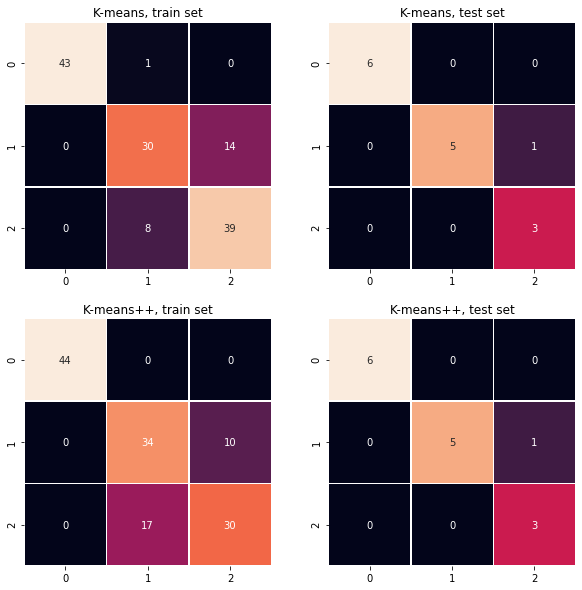

In [27]:
# and plot out confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(10,10))
fig = plt.subplot(2, 2, 1)
sn.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cbar=False, square=True, linewidths=0.5)
fig.set_title('K-means, train set')

fig = plt.subplot(2, 2, 2)
sn.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cbar=False, square=True, linewidths=0.5)
fig.set_title('K-means, test set')

fig = plt.subplot(2, 2, 3)
sn.heatmap(confusion_matrix(y_train, y_train_pred_pp), annot=True, cbar=False, square=True, linewidths=0.5)
fig.set_title('K-means++, train set')

fig = plt.subplot(2, 2, 4)
sn.heatmap(confusion_matrix(y_test, y_test_pred_pp), annot=True, cbar=False, square=True, linewidths=0.5)
fig.set_title('K-means++, test set');